In [6]:
%matplotlib inline
from matplotlib import pyplot as plt
from skimage.color import rgb2hed, hed2rgb
import matplotlib as mp
import numpy as np
import math as mt

from pylab import *
from scipy import *

from ipywidgets import *

%matplotlib inline  

# ROZWAZANY PRZEDZIAL ([T0, T1])
signalScale = [0.0, 4.0]
# WYSWIETLANA SKALA NA WYKRESIE (DZIEDZINA CZASU)
timePlotXScale = [0.0, 4.0]
# WYSWIETLANA SKALA Y (DZIEDZINA CZASU)
timePloyYScale = [-3.0, 3.0] 

def changeX(left = 10, right = 20, speed = 10.0):
    def dynamicX(x):
        result = x
        if x >= left and x <= right:
            angle = (x - left)/(right-left)*(mt.pi)
            shift = (mt.cos(angle + mt.pi) + 1.0) / 2.0
            result = result + shift * speed
        if x > right:
            result = result + 1.0 * speed
        return result
    return dynamicX

def changeY(left = 5, right = 15, amplitude = 1.0):
    def dynamicY(y, x):
        result = y
        if x >= left and x <= right:
            angle = (x - left)/(right-left)*(2.0*mt.pi)
            shift = (mt.cos(angle + mt.pi) + 1.0) / 2.0
            result = y + shift * amplitude
        return result
    return dynamicY



# KLASA SCENARIO
# PO PROSTU LISTA SIGNALOW 
class Scenario(Widget):
    def __init__(self, signals):
        self.signals = signals
        
# KLASA SYGNAL - PROSTY(SIN)
class Signal:
    def __init__(self, amplitude = 1.0, frequency = 0.5, phase = 0.0, yTranslation = 0.0, color='blue', 
                 changeX=changeX(-1,-1,0), changeY=changeY(-1,-1,0)):
        self.amplitude = amplitude
        self.frequency = frequency
        self.phase = phase
        self.yTranslation = yTranslation
        self.color = color
        self.changeX = changeX
        self.changeY = changeY
        
    #LISTA X, Y DLA ZADANEGO PRZEDZIALU I CZESTOTLIWOSCI PROBKOWANIA
    def getDataForRange(self, scale, samplingFrequency):
        x = np.arange(scale[0], scale[1], 1.0 / samplingFrequency)
        fs = lambda a: (self.amplitude * mt.sin(self.phase + self.changeX(a) * self.frequency * 2.0 * mt.pi) + self.yTranslation)
        y = [self.changeY(fs(a), a) for a in x ]
        return x, y

# WYLICZA WYNIKOWY SYGNAL ZE SKLADOWYCH
def getFinalSignal(signals, samplingFrequency):
    x = []
    y = []
    for s in signals:
        data = s.getDataForRange(signalScale, samplingFrequency)
        if len(x) == 0: x = data[0]
        if not y: y = [0] * len(x)
        for i in range(len(x)):
            y[i] = y[i] + data[1][i]
    return x, y
   
# --- RYSOWANIE WSZYSTKIEGO
# --- SINGLE - NA WEJSCIU PARAMETRY DLA POJEDYNCZEGO SYGNALU
# --- ALL - NA WEJSCIU SCENARIO



def plotSingle(
            amplitude=1.0, 
            frequency=0.5, 
            phase=0.0, 
            yTranslation=0.0,
            samplingFrequency=10.0, 
            showComponents=True, 
            showFinal=False, 
            showFrequencyDomain=False, 
            showSymmetrical=False,
            showInverseFFT=False):
    
    scenario = Scenario([Signal(amplitude, frequency, phase, yTranslation)])
    plotAll(scenario, samplingFrequency, showComponents, showFinal, showFrequencyDomain, showSymmetrical, showInverseFFT)
    
def plotAllWithNoiseCancel(
            scenario = Scenario([Signal(amplitude=1.0, frequency=0.5, phase=0.0, yTranslation=0.0, color='blue')]),
            samplingFrequency=10.0, 
            noiseThreshold=10000.0,
            showComponents=True, 
            showFinal=False, 
            showFrequencyDomain=False, 
            showSymmetrical=False, 
            showInverseFFT=False,
            showSpectrogram=False,
            windowSize=2.0,
            windowJump=0.5):
    
    signals = scenario.signals
    
    # --- CONSTRUCT FIGURE AND SUBPLOTS ------------------------
    if showFrequencyDomain or showInverseFFT or showSpectrogram:
        column_width_pt = 1000.0
    else:
        column_width_pt = 500.0
        
    pt_per_inch = 72
    size = column_width_pt / pt_per_inch;
    height = 0.55
    
    total = 1 + sum([showFrequencyDomain, showInverseFFT, showSpectrogram])
    if total in [2, 3]: height = 0.37

    fig = plt.figure(1, figsize=(size, height * size))
    sub = fig.add_subplot(1, total, 1)
    if showFrequencyDomain:
        subFreq = fig.add_subplot(1, total, 2)
    if showInverseFFT:    
        subIFFT = fig.add_subplot(1, total, 2 if not showFrequencyDomain else 3)

    if showSpectrogram:
        subSpectr = fig.add_subplot(1, total, total)
    # ------------------------------------------------------
    # --- TIME DOMAIN --------------------------------------
            
    sub.set_xlabel('Time [s]')
    sub.set_ylabel('y = signal(x)')
    sub.grid('on', axis='both', color='gray', linewidth=1.25)
    
    sub.set_xlim(timePlotXScale)
    sub.set_ylim(timePloyYScale)
    
    if showComponents:
        for s,_ in enumerate(signals):
            data = signals[s].getDataForRange(signalScale, samplingFrequency)
            #Å»EBY BYLO PRZEJRZYSCIEJ
            if samplingFrequency < 8.0:
                sub.plot(data[0], data[1], marker='o', linestyle='---', color = signals[s].color)
            else:
                sub.plot(data[0], data[1], linestyle='-', color = signals[s].color)
    
    dataFinal = getFinalSignal(signals, samplingFrequency)
    if showFinal:
        dataFinal = getFinalSignal(signals, samplingFrequency)
        sub.plot(dataFinal[0], dataFinal[1], linestyle='-', linewidth = 2.0, color = 'red')
        
    # ------------------------------------------------------
    # --- FREQUENCY DOMAIN --------------------------------------
    
    ind = np.arange(len(dataFinal[0]))  # the x locations for the groups   
    signal1 = np.fft.fft(dataFinal[1])
    signal2 = abs(signal1) 

    ffty = signal2
    freq = [v * samplingFrequency / len(dataFinal[0]) for v in ind]
    
    # USUWAMY PASMO
    signal3 = []
    for i in range(len(freq)):
        if noiseThreshold <= samplingFrequency / 2:
            if freq[i] <= samplingFrequency / 2 and freq[i] >= noiseThreshold:
                ffty[i] = 0.0
                signal1[i] = 0.0
            if freq[i] >= samplingFrequency / 2 and freq[i] <= samplingFrequency - noiseThreshold:
                ffty[i] = 0.0
                signal1[i] = 0.0
    
    if showSymmetrical == False:
        freq = freq[:len(signal2)//2]
        ffty = ffty[:len(signal2)//2]
 
    if showFrequencyDomain == True:
        
        subFreq.set_xlabel('Frequency [Hz]')
        subFreq.set_ylabel('Amplitude')
        subFreq.grid('on', axis='both', color='gray', linewidth=1.25)
            
        #TRANSFORM
        subFreq.set_ylim([0.0, 80.0])
        white_space = freq[-1]/len(freq)*2
        subFreq.set_xlim([-white_space, freq[-1]+white_space])
        barFreq = subFreq.stem(freq, ffty, '-*', color='blue')
    
    # ------------------------------------------------------
    # --- INVERSE FFT --------------------------------------
    if showInverseFFT == True:
        subIFFT.set_xlabel('Time [s]')
        subIFFT.set_ylabel('y = signal(x)')
        subIFFT.grid('on', axis='both', color='gray', linewidth=1.25)
    
        subIFFT.set_xlim(timePlotXScale)
        subIFFT.set_ylim(timePloyYScale)
        
        signalIFFT = np.fft.ifft(signal1)
        
        
        subIFFT.plot(dataFinal[0], np.real(signalIFFT), linestyle='-', linewidth = 2.0, color = 'red')
   
    # ------------------------------------------------------
    # --- SHOW SPECTROGRAM --------------------------------------
    if showSpectrogram == True:
        subSpectr.set_xlabel('Time [s]')
        subSpectr.set_ylabel('Frequency [Hz]')
        subSpectr.grid('on', axis='both', color='gray', linewidth=1.25)
    
        xlabel = []
        data = []
        
        start = 0;
        startInDomain = 0
        windowSizeInDomain = windowSize * samplingFrequency
        jumpInDomain = windowJump * samplingFrequency
        
        while startInDomain + windowSizeInDomain <= len(dataFinal[0]):
            
            xlabel.append(start)
            portion = []
            for i in range(int(startInDomain), int(startInDomain + windowSizeInDomain)):
                 portion.append(dataFinal[1][i])
                    
            toAdd = abs(np.fft.fft(portion))
            if showSymmetrical == False:
                toAdd = toAdd[0:int(len(toAdd)/ 2)]
                
            data.append(toAdd)
            
            start += windowJump
            startInDomain += jumpInDomain
            
            
        npdata = np.array(data)
        npdata = np.transpose(npdata)
        
        subSpectr.set_xlim(0, len(npdata[0]))
        subSpectr.set_ylim(0, len(npdata))
            
        heatmap = subSpectr.pcolor(npdata)
        fig.colorbar(heatmap)
                
    plt.show()

In [7]:
def plotSpectrogram(scenario = Scenario([Signal(amplitude = 1.0, frequency = 0.5, phase = 0.0, yTranslation = 0.0, color='blue')]),
            samplingFrequency = 10.0, 
            showComponents = True, 
            showFinal=False, 
            showFrequencyDomain=False, 
            showSymmetrical=False, 
            showSpectrogram=False,
            windowSize = 2.0,
            windowJump = 0.5):
    
    plotAllWithNoiseCancel(scenario, samplingFrequency, 1000000.0, showComponents, showFinal, 
                           showFrequencyDomain, showSymmetrical, False, showSpectrogram,
            windowSize,
            windowJump)
    
    
def plotAllWithNoiseCancelWithoutSpectrogram(scenario = Scenario([Signal(amplitude = 1.0, frequency = 0.5, phase = 0.0, yTranslation = 0.0, color='blue')]),
            samplingFrequency = 10.0, 
            noiseThreshold = 10000.0,
            showComponents = True, 
            showFinal=False, 
            showFrequencyDomain=False, 
            showSymmetrical=False, 
            showInverseFFT=False):
    
    plotAllWithNoiseCancel(scenario, samplingFrequency, noiseThreshold, showComponents, showFinal, 
                           showFrequencyDomain, showSymmetrical, showInverseFFT, showSpectrogram=False,
            windowSize = 2.0,
            windowJump = 0.5)
    
# --- WA - BEZ CZESCI PARAMETROW TRUE/FALSE - INACZEJ NIE WIEM JAK WYWALIC WIDGET Z INTERACT
# --- WIFFT - BEZ PARAMETROW IFFT - INACZEJ NIE WIEM JAK WYWALIC WIDGET Z INTERACT
def plotAll(scenario = Scenario([Signal(amplitude = 1.0, frequency = 0.5, phase = 0.0, yTranslation = 0.0, color='blue')]),
            samplingFrequency = 10.0, 
            showComponents = True, 
            showFinal=False, 
            showFrequencyDomain=False, 
            showSymmetrical=False, 
            showInverseFFT=False): 
    
    plotAllWithNoiseCancel(scenario, samplingFrequency, 10000.0, showComponents, showFinal, 
                           showFrequencyDomain, showSymmetrical, showInverseFFT, showSpectrogram=False,
            windowSize = 10,
            windowJump = 3)

def plotSingleWithoutAll(   
    amplitude = 1.0, 
    frequency = 0.5, 
    phase = 0.0, 
    yTranslation = 0.0,
    samplingFrequency = 10.0):
    
    scenario = Scenario([Signal(amplitude, frequency, phase, yTranslation)])
    plotAll(scenario, samplingFrequency)

def plotSingleWIFFT(
    amplitude = 1.0, 
    frequency = 0.5, 
    phase = 0.0, 
    yTranslation = 0.0,
    samplingFrequency = 10.0, 
    showComponents = True, 
    showFinal=False, 
    showFrequencyDomain=False, 
    showSymmetrical=True):
    
    scenario = Scenario([Signal(amplitude, frequency, phase, yTranslation)])
    plotAll(scenario, samplingFrequency, showComponents, showFinal, showFrequencyDomain, showSymmetrical)
    
def plotAllWithoutAll(   
    scenario = Scenario([Signal(amplitude = 1.0, frequency = 0.5, phase = 0.0, yTranslation = 0.0, color='blue')]),
    samplingFrequency = 10.0, 
    showComponents = True, 
    showFinal=False):
    
    plotAll(scenario, samplingFrequency,showComponents, showFinal) 

# SYGNAL W DZIEDZINIE CZASU

## Podstawowe cechy, czestotliwosc probkowania, nyquista

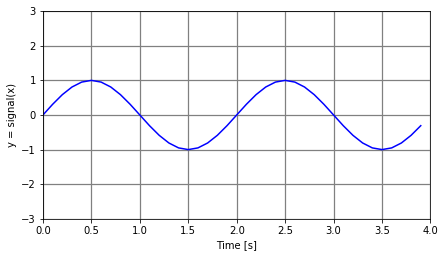

In [8]:
interact(plotSingleWithoutAll, amplitude=(0.5,2.5,0.1),
         frequency=(0.1, 2.0,0.1), phase=(-2*mt.pi, 2*mt.pi, 0.25), 
         yTranslation=(-2.5, 2.5, 0.5), samplingFrequency=(0.25,10,0.25));



## Sumowanie sygnaÅ‚ow

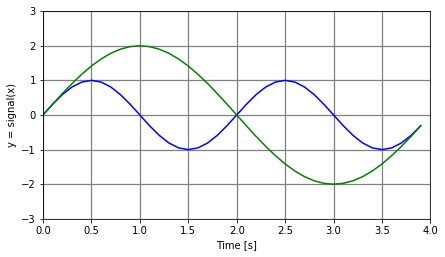

In [9]:
sc1 = Scenario([
        Signal(amplitude = 1.0, frequency = 0.5, phase = 0.0, yTranslation = 0.0, color = 'blue'),
        Signal(amplitude = 2.0, frequency = 0.25, phase = 0.0, yTranslation = 0.0, color = 'green') ])
sc2 = Scenario([
        Signal(amplitude = 1.0, frequency = 0.5, phase = 0.0, yTranslation = 0.0, color = 'blue'),
        Signal(amplitude = 1.25, frequency = 0.5, phase = 0.0, yTranslation = 0.0, color = 'green') ])
sc3 = Scenario([
        Signal(amplitude = 1.0, frequency = 0.5, phase = 0.0, yTranslation = 0.0, color = 'blue'),
        Signal(amplitude = 1.0, frequency = 0.5, phase = mt.pi, yTranslation = 0.0, color = 'green') ])



scenarios = {"1. Przyklad": sc1 , "2. Wzmocnienie" : sc2, "3. Tlumienie" : sc3}
interact(plotAllWithoutAll, scenario=scenarios, samplingFrequency=(0.25,10,0.25));

# SYGNAÅ W DZIEDZINIE CZÄ˜STOTLIWOÅšCI

## FFT

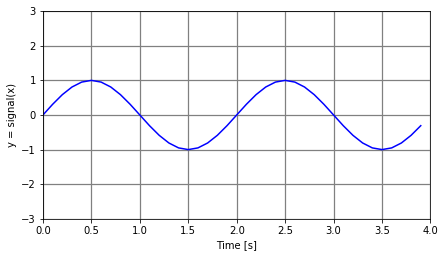

In [10]:
#TODO: Po co tu showFinal?
interact(plotSingleWIFFT, amplitude=(0.5,2.5,0.1),
         frequency=(0.05, 2.0, 0.05), phase = (-2*mt.pi, 2*mt.pi, 0.25), 
         yTranslation=(-2.5, 2.5, 0.5), samplingFrequency=(0.25, 10, 0.25));

## Suma sygnalow w dziedzinie czasu a efekt w dziedzinie czestotliwosci oraz odwrotne FFT

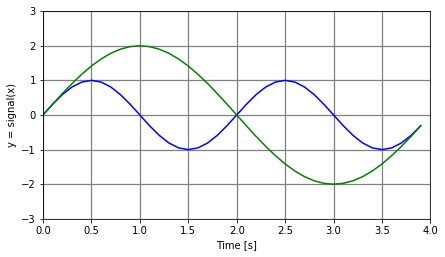

In [11]:
sc1 = Scenario([
        Signal(amplitude = 1.0, frequency = 0.5, phase = 0.0, yTranslation = 0.0, color = 'blue'),
        Signal(amplitude = 2.0, frequency = 0.25, phase = 0.0, yTranslation = 0.0, color = 'green') ])
sc2 = Scenario([
        Signal(amplitude = 1.0, frequency = 0.5, phase = 0.0, yTranslation = 0.0, color = 'blue'),
        Signal(amplitude = 1.25, frequency = 0.5, phase = 0.0, yTranslation = 0.0, color = 'green') ])
sc3 = Scenario([
        Signal(amplitude = 1.0, frequency = 0.5, phase = 0.0, yTranslation = 0.0, color = 'blue'),
        Signal(amplitude = 1.0, frequency = 0.5, phase = mt.pi, yTranslation = 0.0, color = 'green') ])

scenarios = {"1. Przyklad": sc1 , "2. Wzmocnienie" : sc2, "3. Tlumienie" : sc3}
interact(plotAll, scenario=scenarios, samplingFrequency=(0.25,10,0.25));

#TODO: Po co tutaj inverseFFT?

## Proste filtrowanie (FFT i iFFT)

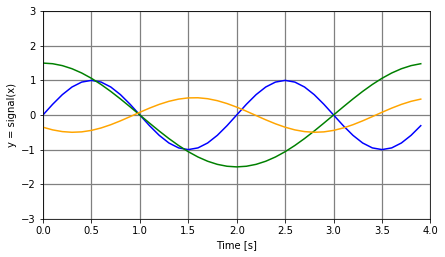

In [13]:
l1 = [
        Signal(amplitude=1.0, frequency=0.5,  phase=0.0, yTranslation = 0.0, color = 'blue'),
        Signal(amplitude=1.5, frequency=0.25, phase=0.5 * mt.pi, yTranslation = 0.0, color = 'green'),
        Signal(amplitude=0.5, frequency=0.4,  phase=1.25 * mt.pi, yTranslation = 0.0, color = 'orange')]

l2 = [
        Signal(amplitude=1.0, frequency=0.5,  phase=0.0, yTranslation = 0.0, color = 'blue'),
        Signal(amplitude=1.5, frequency=0.25, phase=0.5 * mt.pi, yTranslation = 0.0, color = 'green'),
        Signal(amplitude=0.5, frequency=0.4,  phase=1.25 * mt.pi, yTranslation = 0.0, color = 'orange')]

for i in range(50):
    amplitude = 0.05 + random.random() * 0.15
    #Round - UnikniÄ™cie bÅ‚Ä™dÃ³w numerycznych, co sie stanie po usunieciu round?
    # frequency = round(1.0 + random.random() * 3.0, 1)
    frequency = round(1.0 + random.random() * 3.0, 1) 
    phase = random.random() * mt.pi
    color = 'black'
    l2.append(Signal(amplitude, frequency, phase, 0.0, color))

sc1 = Scenario(l1)
sc2 = Scenario(l2)

scenarios = {"1. Przyklad": sc1, "2. Noise": sc2 }
interact(plotAllWithNoiseCancelWithoutSpectrogram, scenario=scenarios, noiseThreshold=6.0, samplingFrequency=(0.25,10,0.25));

## Pojedynczy sygnal - zmienny w czasie

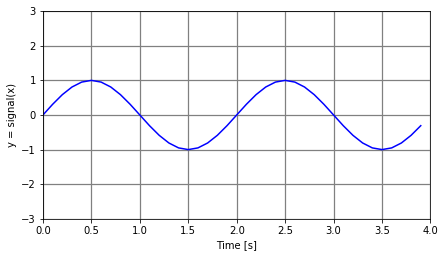

In [14]:
sc1 = Scenario([
        Signal(amplitude = 1.0, frequency = 0.5, phase = 0.0, yTranslation = 0.0, color = 'blue', 
               changeX=changeX(5,15,10))])
sc2 = Scenario([
        Signal(amplitude = 1.0, frequency = 0.5, phase = 0.0, yTranslation = 0.0, color = 'blue', 
               changeY=changeY(5,15,1))])
sc3 = Scenario([
        Signal(amplitude = 1.0, frequency = 0.5, phase = 0.0, yTranslation = 0.0, color = 'blue', 
               changeX=changeX(10,20,10), changeY=changeY(0,10,1))])


scenarios = {"1. Zmienna czestotliwosc": sc1 , "2. Zmienna amplituda" : sc2, "3. Mix" : sc3}
interact(plotAll, scenario=scenarios, samplingFrequency=(0.25,10,0.25));

## Spectrogram

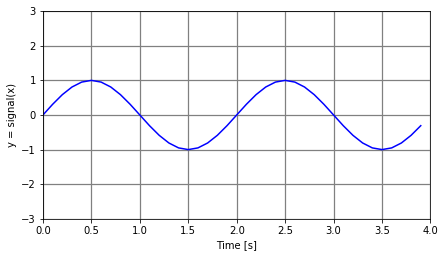

In [15]:

sc1 = Scenario([
        Signal(amplitude = 1.0, frequency = 0.5, phase = 0.0, yTranslation = 0.0, color = 'blue', 
               changeX=changeX(5,15,10))])
sc2 = Scenario([
        Signal(amplitude = 1.0, frequency = 0.5, phase = 0.0, yTranslation = 0.0, color = 'blue', 
               changeY=changeY(5,15,1))])
sc3 = Scenario([
        Signal(amplitude = 1.0, frequency = 0.5, phase = 0.0, yTranslation = 0.0, color = 'blue', 
               changeX=changeX(10,20,10), changeY=changeY(0,10,1))])

scenarios = {"1. Czestotliwosc": sc1, "2. Aplituda": sc2, "3. Mix": sc3   }
interact(plotSpectrogram, scenario=scenarios, samplingFrequency=(0.25,10,0.25), windowSize=(4.0,10.0,0.25), 
         windowJump=(0.25,2.0,0.25));
